In [1]:
# 3-Layer CNN for Colored MNIST Classification
# Converted from task1_v2.ipynb

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# ===== CONFIGURATION =====
# All hyperparameters and settings in one place

# Data paths
TRAIN_DATA_PATH = '/kaggle/input/cmnistneo1/train_data_rg95z.npz'
TEST_DATASETS = {
    'rg95z': '/kaggle/input/cmnistneo1/test_data_rg95z.npz',
    'gr95z': '/kaggle/input/cmnistneo1/test_data_gr95z.npz',
    'gr95e': '/kaggle/input/cmnistneo1/test_data_gr95e.npz',
    'gr95m': '/kaggle/input/cmnistneo1/test_data_gr95m.npz',
    'gr95h': '/kaggle/input/cmnistneo1/test_data_gr95h.npz',
    'gr95vh': '/kaggle/input/cmnistneo1/test_data_gr95vh.npz',
    'bw95z': '/kaggle/input/cmnistneo1/test_data_bw95z.npz',
    'bw100z': '/kaggle/input/cmnistneo1/test_data_bw100z.npz'
}

# Model hyperparameters
NUM_CLASSES = 10
CONV1_CHANNELS = 32
CONV2_CHANNELS = 64
CONV3_CHANNELS = 64
FC1_UNITS = 128
DROPOUT_RATE = 0.0

# Training hyperparameters
EPOCHS = 20
BATCH_SIZE = 128
LEARNING_RATE = 0.02
VALIDATION_SPLIT = 0.1

# Optimizer settings
OPTIMIZER = 'Adam'  # Options: 'Adam', 'SGD', 'RMSprop'

NAME = 'task1approach4gf1'

# ===== END CONFIGURATION =====


In [2]:

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load training data
train_data = np.load(TRAIN_DATA_PATH)
X_train = train_data['images']
y_train = train_data['labels']

# Load test datasets from dictionary
test_data_dict = {}
for name, path in TEST_DATASETS.items():
    data = np.load(path)
    test_data_dict[name] = {
        'images': data['images'],
        'labels': data['labels']
    }
    print(f"{name} shape: {data['images'].shape}, labels: {data['labels'].shape}")

print(f"\nTraining data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Number of classes: {len(np.unique(y_train))}")

# Normalize pixel values to [0, 1]
X_train = X_train.astype('float32') / 255.0

# Normalize test datasets
for name in test_data_dict:
    test_data_dict[name]['images'] = test_data_dict[name]['images'].astype('float32') / 255.0

# Create validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=VALIDATION_SPLIT, random_state=42
)

# Convert to PyTorch tensors and change format from (N, H, W, C) to (N, C, H, W)
X_train_tensor = torch.FloatTensor(X_train).permute(0, 3, 1, 2)
X_val_tensor = torch.FloatTensor(X_val).permute(0, 3, 1, 2)

y_train_tensor = torch.LongTensor(y_train)
y_val_tensor = torch.LongTensor(y_val)

# Convert test datasets to tensors
test_tensors = {}
for name in test_data_dict:
    X_test = test_data_dict[name]['images']
    y_test = test_data_dict[name]['labels']
    
    test_tensors[name] = {
        'X': torch.FloatTensor(X_test).permute(0, 3, 1, 2),
        'y': torch.LongTensor(y_test)
    }

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Create test loaders
test_loaders = {}
for name in test_tensors:
    dataset = TensorDataset(test_tensors[name]['X'], test_tensors[name]['y'])
    test_loaders[name] = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training set: {X_train_tensor.shape}")
print(f"Validation set: {X_val_tensor.shape}")
for name in test_tensors:
    print(f"Test set {name}: {test_tensors[name]['X'].shape}")
print(f"Input shape: {X_train_tensor.shape[1:]}")

# Helper function to create Gaussian kernel
def create_gaussian_kernel(kernel_size=3, sigma=11.0):
    """
    Create a 2D Gaussian kernel for filtering.
    
    Args:
        kernel_size: Size of the kernel (default: 3)
        sigma: Standard deviation of the Gaussian distribution (default: 1.0)
    
    Returns:
        Normalized Gaussian kernel of shape (kernel_size, kernel_size)
    """
    # Create a coordinate grid
    ax = np.arange(-kernel_size // 2 + 1., kernel_size // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    
    # Calculate Gaussian kernel
    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    
    # Normalize the kernel
    kernel = kernel / np.sum(kernel)
    
    return kernel


PyTorch version: 2.8.0+cu126
CUDA available: True
Using device: cuda
rg95z shape: (10000, 28, 28, 3), labels: (10000,)
gr95z shape: (10000, 28, 28, 3), labels: (10000,)
gr95e shape: (10000, 28, 28, 3), labels: (10000,)
gr95m shape: (10000, 28, 28, 3), labels: (10000,)
gr95h shape: (10000, 28, 28, 3), labels: (10000,)
gr95vh shape: (10000, 28, 28, 3), labels: (10000,)
bw95z shape: (10000, 28, 28, 3), labels: (10000,)
bw100z shape: (10000, 28, 28, 3), labels: (10000,)

Training data shape: (60000, 28, 28, 3)
Training labels shape: (60000,)
Number of classes: 10
Training set: torch.Size([54000, 3, 28, 28])
Validation set: torch.Size([6000, 3, 28, 28])
Test set rg95z: torch.Size([10000, 3, 28, 28])
Test set gr95z: torch.Size([10000, 3, 28, 28])
Test set gr95e: torch.Size([10000, 3, 28, 28])
Test set gr95m: torch.Size([10000, 3, 28, 28])
Test set gr95h: torch.Size([10000, 3, 28, 28])
Test set gr95vh: torch.Size([10000, 3, 28, 28])
Test set bw95z: torch.Size([10000, 3, 28, 28])
Test set bw10

In [3]:

# Build the 3-Layer CNN Model
class CNN3Layer(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, use_gaussian_conv1=True):
        super(CNN3Layer, self).__init__()
        
        self.use_gaussian_conv1 = use_gaussian_conv1

        # First Convolutional Layer
        self.conv1 = nn.Conv2d(3, CONV1_CHANNELS, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)

        # Second Convolutional Layer
        self.conv2 = nn.Conv2d(CONV1_CHANNELS, CONV2_CHANNELS, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Third Convolutional Layer
        self.conv3 = nn.Conv2d(CONV2_CHANNELS, CONV3_CHANNELS, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(CONV3_CHANNELS * 3 * 3, FC1_UNITS)
        self.dropout = nn.Dropout(DROPOUT_RATE)
        self.fc2 = nn.Linear(FC1_UNITS, num_classes)
        
        # Initialize first conv layer with Gaussian filter if enabled
        if self.use_gaussian_conv1:
            self._initialize_gaussian_conv1()
    
    def _initialize_gaussian_conv1(self):
        """
        Initialize the first convolutional layer with Gaussian filter weights.
        This creates a hybrid approach where conv1 uses Gaussian filtering.
        """
        # Create Gaussian kernel
        gaussian_kernel = create_gaussian_kernel(kernel_size=3, sigma=51.0)
        
        # Get the weight tensor of conv1
        # Shape: (out_channels, in_channels, kernel_height, kernel_width)
        # For conv1: (32, 3, 3, 3)
        with torch.no_grad():
            # Initialize all weights with the Gaussian kernel
            for out_ch in range(self.conv1.out_channels):
                for in_ch in range(self.conv1.in_channels):
                    # Apply Gaussian kernel to each channel combination
                    self.conv1.weight[out_ch, in_ch] = torch.FloatTensor(gaussian_kernel)
            
            # Initialize biases to zero for the first layer
            if self.conv1.bias is not None:
                self.conv1.bias.zero_()

    def forward(self, x):
        # First conv block
        x = self.pool1(F.relu(self.conv1(x)))

        # Second conv block
        x = self.pool2(F.relu(self.conv2(x)))

        # Third conv block
        x = self.pool3(F.relu(self.conv3(x)))

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x


In [4]:

# Initialize model and move to device
model = CNN3Layer(num_classes=NUM_CLASSES).to(device)

# Display model architecture
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
print("\n" + "="*60)
print("HYBRID FILTERING APPROACH")
print("="*60)
print("Conv Layer 1: Gaussian filter initialization (sigma=1.0)")
print("Conv Layer 2: Standard PyTorch initialization (Kaiming uniform)")
print("Conv Layer 3: Standard PyTorch initialization (Kaiming uniform)")
print("="*60 + "\n")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

if OPTIMIZER == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
elif OPTIMIZER == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
elif OPTIMIZER == 'RMSprop':
    optimizer = optim.RMSprop(model.parameters(), lr=LEARNING_RATE)
else:
    raise ValueError(f"Unknown optimizer: {OPTIMIZER}")

print("Model compiled successfully!")
print(f"Optimizer: {OPTIMIZER}")
print(f"Loss function: CrossEntropyLoss")

# Lists to store history
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

# Training loop
for epoch in range(EPOCHS):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)
        loss = criterion(output, target)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        train_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        train_total += target.size(0)
        train_correct += (predicted == target).sum().item()

    # Calculate average training metrics
    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = train_correct / train_total

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            val_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            val_total += target.size(0)
            val_correct += (predicted == target).sum().item()

    # Calculate average validation metrics
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = val_correct / val_total

    # Store history
    train_loss_history.append(avg_train_loss)
    train_acc_history.append(train_accuracy)
    val_loss_history.append(avg_val_loss)
    val_acc_history.append(val_accuracy)

    # Print epoch results
    print(f'Epoch [{epoch+1}/{EPOCHS}] - '
          f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f} - '
          f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

print("\nTraining completed!")


CNN3Layer(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=576, out_features=128, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

Total parameters: 131,466

HYBRID FILTERING APPROACH
Conv Layer 1: Gaussian filter initialization (sigma=1.0)
Conv Layer 2: Standard PyTorch initialization (Kaiming uniform)
Conv Layer 3: Standard PyTorch initialization (Kaiming uniform)

Model compiled successfully!
Optimizer: Adam
Loss function: CrossEntropyLoss
Epoch [1/20] - T

In [5]:

# Save the model
model_save_path = NAME+'_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"\nModel state dict saved to: {model_save_path}")

# Optionally save the entire model
full_model_path = NAME+'_full_model.pth'
torch.save(model, full_model_path)
print(f"Full model saved to: {full_model_path}")

# Save training history
history_path = NAME+'_training_history.npz'
np.savez(history_path,
         train_loss=train_loss_history,
         train_acc=train_acc_history,
         val_loss=val_loss_history,
         val_acc=val_acc_history)
print(f"Training history saved to: {history_path}")

# Save model metadata
metadata_path = NAME+'_metamodel.txt'
with open(metadata_path, 'w') as f:
    f.write("="*60 + "\n")
    f.write("MODEL METADATA\n")
    f.write("="*60 + "\n\n")
    
    f.write("MODEL NAME:\n")
    f.write("  3-Layer CNN for Colored MNIST Classification\n\n")
    
    f.write("MODEL ARCHITECTURE:\n")
    f.write(str(model) + "\n\n")
    
    f.write("MODEL STRUCTURE:\n")
    f.write("  HYBRID FILTERING APPROACH:\n")
    f.write("  - Conv1: Gaussian filter initialization (sigma=1.0)\n")
    f.write("  - Conv2 & Conv3: Standard PyTorch initialization\n\n")
    f.write("  Layer 1: Conv2d(3 -> 32, kernel=3x3, padding=1, Gaussian init) + ReLU + MaxPool2d(2x2)\n")
    f.write("  Layer 2: Conv2d(32 -> 64, kernel=3x3, padding=1) + ReLU + MaxPool2d(2x2)\n")
    f.write("  Layer 3: Conv2d(64 -> 64, kernel=3x3, padding=1) + ReLU + MaxPool2d(2x2)\n")
    f.write("  FC Layer 1: Linear(576 -> 128) + ReLU + Dropout(0.5)\n")
    f.write("  FC Layer 2: Linear(128 -> 10)\n\n")
    
    f.write("TOTAL PARAMETERS:\n")
    f.write(f"  {sum(p.numel() for p in model.parameters()):,}\n\n")
    
    f.write("HYPERPARAMETERS:\n")
    f.write(f"  Epochs: {EPOCHS}\n")
    f.write(f"  Batch Size: {BATCH_SIZE}\n")
    f.write(f"  Learning Rate: {LEARNING_RATE}\n")
    f.write(f"  Optimizer: {OPTIMIZER}\n")
    f.write(f"  Loss Function: CrossEntropyLoss\n")
    f.write(f"  Dropout Rate: {DROPOUT_RATE}\n")
    f.write(f"  Validation Split: {VALIDATION_SPLIT} ({VALIDATION_SPLIT*100:.0f}%)\n\n")
    
    f.write("INPUT SPECIFICATIONS:\n")
    f.write(f"  Input Shape: {X_train_tensor.shape[1:]}\n")
    f.write(f"  Number of Classes: {NUM_CLASSES}\n")
    f.write(f"  Image Size: 28x28x3 (RGB)\n\n")
    
    f.write("TRAINING DATA:\n")
    f.write(f"  Training Samples: {len(X_train_tensor)}\n")
    f.write(f"  Validation Samples: {len(X_val_tensor)}\n\n")
    
    f.write("TEST DATASETS:\n")
    for name in test_tensors:
        f.write(f"  {name}: {len(test_tensors[name]['X'])} samples\n")
    f.write("\n")
    
    f.write("FINAL TRAINING METRICS:\n")
    f.write(f"  Final Training Loss: {train_loss_history[-1]:.4f}\n")
    f.write(f"  Final Training Accuracy: {train_acc_history[-1]*100:.2f}%\n")
    f.write(f"  Final Validation Loss: {val_loss_history[-1]:.4f}\n")
    f.write(f"  Final Validation Accuracy: {val_acc_history[-1]*100:.2f}%\n\n")
    
    f.write("SAVED FILES:\n")
    f.write(f"  Model State Dict: {model_save_path}\n")
    f.write(f"  Full Model: {full_model_path}\n")
    f.write(f"  Training History: {history_path}\n")
    f.write(f"  Metadata: {metadata_path}\n\n")
    
    f.write("="*60 + "\n")

print(f"Model metadata saved to: {metadata_path}")



Model state dict saved to: task1approach4gf1_model.pth
Full model saved to: task1approach4gf1_full_model.pth
Training history saved to: task1approach4gf1_training_history.npz
Model metadata saved to: task1approach4gf1_metamodel.txt



rg95z Results:
  Loss: 0.0794
  Accuracy: 0.9860 (98.60%)

gr95z Results:
  Loss: 9.8758
  Accuracy: 0.2893 (28.93%)

gr95e Results:
  Loss: 5.9417
  Accuracy: 0.1892 (18.92%)

gr95m Results:
  Loss: 5.2596
  Accuracy: 0.1774 (17.74%)

gr95h Results:
  Loss: 4.7482
  Accuracy: 0.1592 (15.92%)

gr95vh Results:
  Loss: 4.2634
  Accuracy: 0.1520 (15.20%)

bw95z Results:
  Loss: 2.7736
  Accuracy: 0.6472 (64.72%)

bw100z Results:
  Loss: 2.8853
  Accuracy: 0.6388 (63.88%)


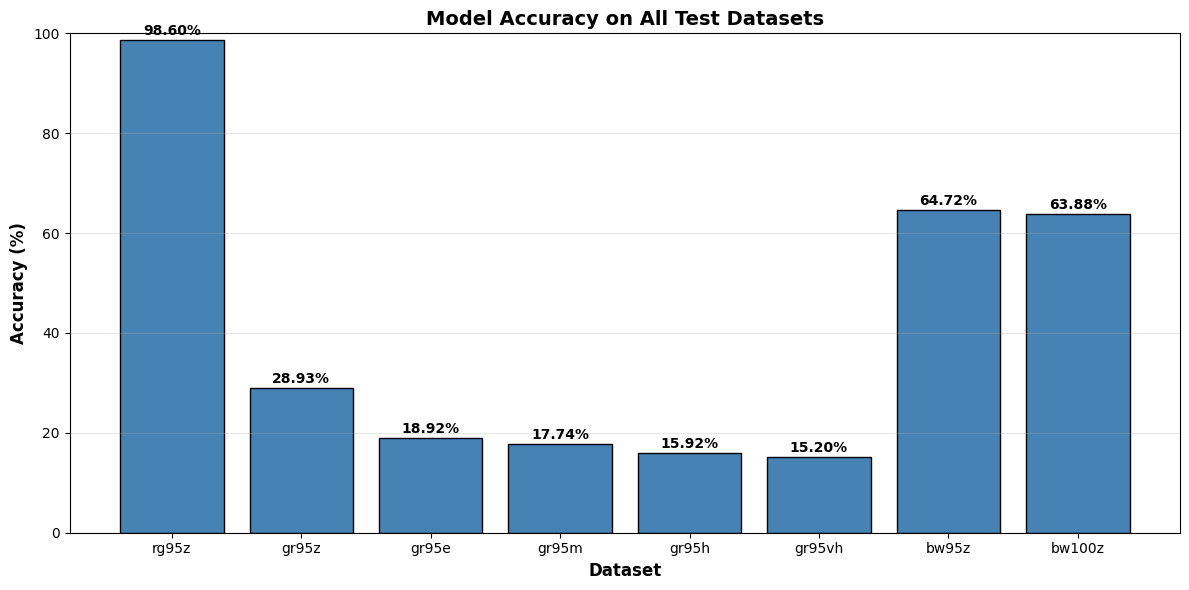

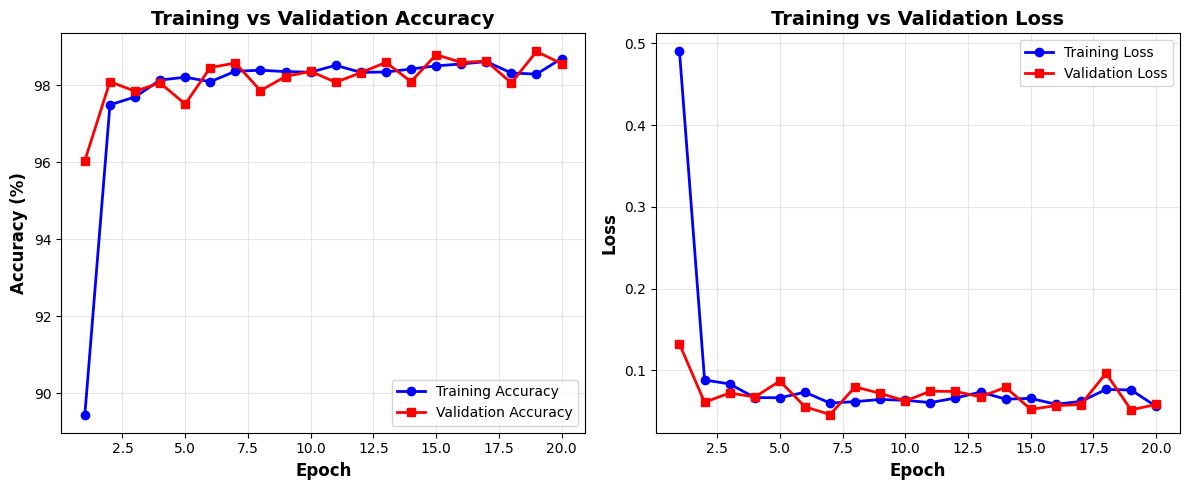

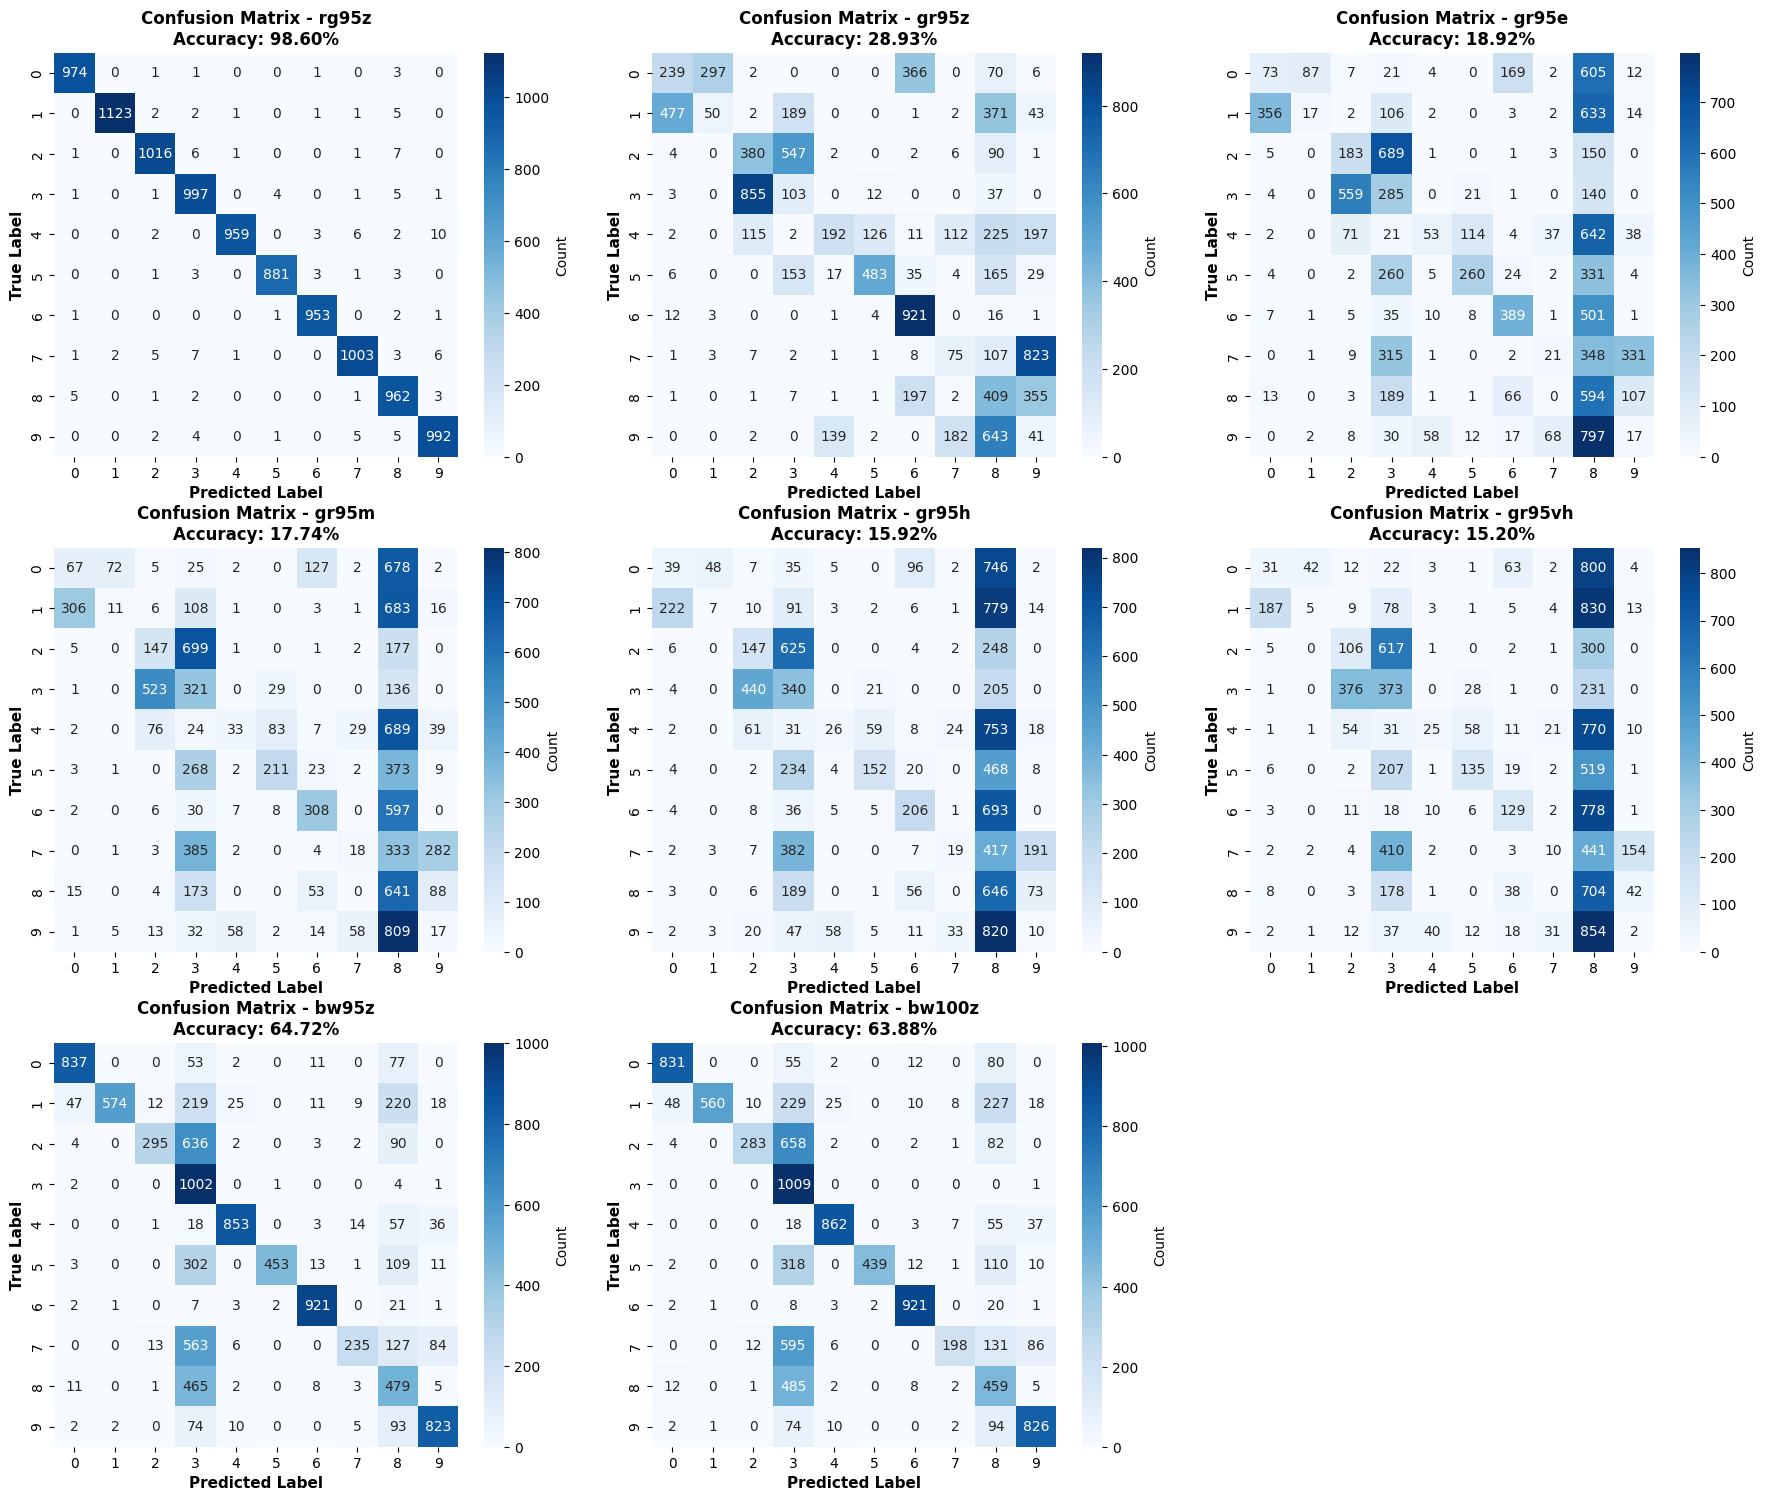


EVALUATION SUMMARY
rg95z          :  98.60%
gr95z          :  28.93%
gr95e          :  18.92%
gr95m          :  17.74%
gr95h          :  15.92%
gr95vh         :  15.20%
bw95z          :  64.72%
bw100z         :  63.88%


In [6]:



# Evaluate on all test datasets
from sklearn.metrics import confusion_matrix
import seaborn as sns

test_results = {}
all_predictions = {}
all_targets = {}

for name, loader in test_loaders.items():
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    predictions = []
    targets = []
    
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            
            test_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            test_total += target.size(0)
            test_correct += (predicted == target).sum().item()
            
            predictions.extend(predicted.cpu().numpy())
            targets.extend(target.cpu().numpy())
    
    avg_test_loss = test_loss / len(loader)
    test_accuracy = test_correct / test_total
    
    test_results[name] = {
        'loss': avg_test_loss,
        'accuracy': test_accuracy
    }
    all_predictions[name] = np.array(predictions)
    all_targets[name] = np.array(targets)
    
    print(f"\n{name} Results:")
    print(f"  Loss: {avg_test_loss:.4f}")
    print(f"  Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Visualization 1: Accuracy comparison across all datasets
plt.figure(figsize=(12, 6))
dataset_names = list(test_results.keys())
accuracies = [test_results[name]['accuracy'] * 100 for name in dataset_names]

plt.bar(dataset_names, accuracies, color='steelblue', edgecolor='black')
plt.xlabel('Dataset', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
plt.title('Model Accuracy on All Test Datasets', fontsize=14, fontweight='bold')
plt.ylim(0, 100)
plt.grid(axis='y', alpha=0.3)

for i, (name, acc) in enumerate(zip(dataset_names, accuracies)):
    plt.text(i, acc + 1, f'{acc:.2f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('accuracy_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Visualization 2: Training and Validation Accuracy vs Epoch
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
epochs_range = range(1, len(train_acc_history) + 1)
plt.plot(epochs_range, [acc * 100 for acc in train_acc_history], 'b-o', label='Training Accuracy', linewidth=2)
plt.plot(epochs_range, [acc * 100 for acc in val_acc_history], 'r-s', label='Validation Accuracy', linewidth=2)
plt.xlabel('Epoch', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
plt.title('Training vs Validation Accuracy', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss_history, 'b-o', label='Training Loss', linewidth=2)
plt.plot(epochs_range, val_loss_history, 'r-s', label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12, fontweight='bold')
plt.ylabel('Loss', fontsize=12, fontweight='bold')
plt.title('Training vs Validation Loss', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

# Visualization 3: Confusion Matrix for each dataset
num_datasets = len(test_results)
cols = min(3, num_datasets)
rows = (num_datasets + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 5*rows))
if num_datasets == 1:
    axes = [axes]
else:
    axes = axes.flatten() if num_datasets > 1 else [axes]

for idx, name in enumerate(dataset_names):
    cm = confusion_matrix(all_targets[name], all_predictions[name])
    
    ax = axes[idx] if num_datasets > 1 else axes[0]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, 
                cbar_kws={'label': 'Count'}, square=True)
    ax.set_xlabel('Predicted Label', fontsize=11, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=11, fontweight='bold')
    ax.set_title(f'Confusion Matrix - {name}\nAccuracy: {test_results[name]["accuracy"]*100:.2f}%', 
                 fontsize=12, fontweight='bold')

# Hide extra subplots
for idx in range(num_datasets, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*50)
print("EVALUATION SUMMARY")
print("="*50)
for name in dataset_names:
    print(f"{name:15s}: {test_results[name]['accuracy']*100:6.2f}%")
print("="*50)
